In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
%matplotlib inline

In [ ]:
from nmt_run import *

In [3]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_lr_reg/seq2seq_sen-138819_hwy2-dec2_emb-512-h-512__es_c_en_w_gru_drpt-0_noise-0_l2-0.001_cnn-num100-range1-11-2-pool50_35.model
loading ...
finished loading ..


In [5]:
log_dev_fil_name

'fsh_lr_reg/dev_sen-138819_hwy2-dec2_emb-512-h-512__es_c_en_w_gru_drpt-0_noise-0_l2-0.001_cnn-num100-range1-11-2-pool50.log'

In [6]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=5).transpose()

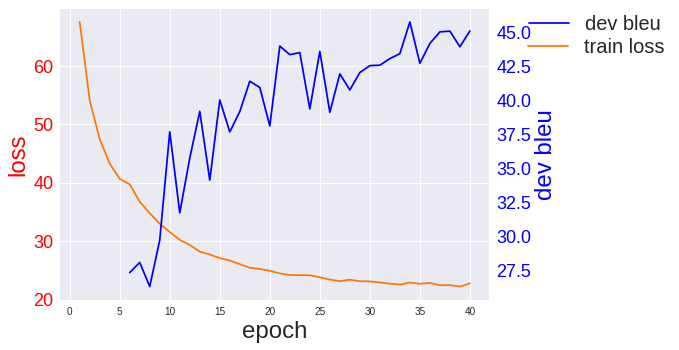

In [7]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
# ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax2.set_ylim(0, 0.9)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [8]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [9]:
cat_speech_path = os.path.join(out_path, key)

In [10]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3979 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 36


/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.functions.pooling.MaxPoolingND is experimental. The interface can change in the future.
  FutureWarning)
b=22,i=50/64,l=174.81,avg=107.51: 100%|█████████▉| 3977/3979 [00:37<00:00, 42.03it/s] 

********** dev mean loss=107.5132
-
--------------------------------------------------------------------------------


In [11]:
display_words(m_dict, v_dict, pred_sents[:50], utts[:50], dec_key)

Utterance: 20051018_210220_279_fsp-A-58
+---------+----------------------------------------------------+
| es ref  | ajá que que sí porque no porque no porque te están |
|         | dando ayuda tu te ves que pudes trabajar sí        |
|         | podemos trabajar pero no tenían yo con dos         |
|         | chiquitos yo digo no puedo trabajar de una vez     |
|         | porque a dónde voy a dejar los chiquitos que tengo |
|         | que pagarle a alguien y no tengo con qué pagarle   |
+---------+----------------------------------------------------+
| en ref  | aha yes because no because no because they are     |
|         | giving you help and you see that you can work we   |
|         | can work but they did not have any with my two     |
|         | children i told myself that i could not work       |
|         | because where would i leave the little ones that i |
|         | have i could have paid someone and i did not have  |
|         | anything to pay them with             

In [12]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)
print("bleu score = {0:.2f}%".format(corpus_bleu(r, h) * 100))

bleu score = 42.76%
